In [1]:
#credits to https://www.pythonforfinance.net/2019/07/02/investment-portfolio-optimisation-with-python-revisited/

import pandas as pd  
import numpy as np
import pandas_datareader.data as web
import datetime as dt
from datetime import date, datetime, timedelta

import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#globals
equities = ['SPY', 'IWM', 'QQQ', 'XLK', 'XLE', 'XRT', 'XRT', 'XLU', 'XLF','XLI','XLV', 'XAR']
fixed_income = ['TLT', 'IEF']
precious_metals = ['GLD', 'GDX', 'SLV', 'GDXJ']

tickers = ['SPY', 'GLD', 'TLT', 'LQD']
start = date.today() - timedelta(days = 3650*1.5)
end = date.today()
rf = 0.0
leverage = 1.5
margin_int = 0.02

In [2]:
#credits to https://www.pythonforfinance.net/2019/07/02/investment-portfolio-optimisation-with-python-revisited/

def get_benchmark(indices,start, end):
    indices = indices

    starter_data = {'benchmark':'0','ret':'0', 'stdev':'0', 'sharpe':'0'}
    df = pd.DataFrame(starter_data, index = starter_data.keys())[0:1].reset_index(drop = True)

    for index in indices:

        series = web.DataReader(index, 'yahoo', start, end)['Adj Close']
        ret = series.pct_change().mean()*252
        stdev = series.pct_change().std()*np.sqrt(252)
        sharpe = (ret-rf)/stdev
        benchmark_data = {'benchmark':index,'ret':ret, 'stdev':stdev, 'sharpe':sharpe}
        new_row = pd.DataFrame(benchmark_data, index = benchmark_data.keys())[0:1].reset_index(drop = True)
        df = df.append(new_row)
    df = df.reset_index(drop = True).drop(0)
    return(df)

def ticker_data(tickers, start, end):
    days = (end-start).days

    index = pd.date_range(start, periods = days, freq='D')
    df = pd.DataFrame(index = index,columns = tickers)

    for ticker in tickers:
        df[ticker] = web.DataReader(ticker, 'yahoo', start, end)['Adj Close']
    df = df.dropna()
    return(df)

def portfolio_data(portfolio, start, end, rf, leverage, margin_int):
    
    weights = np.array(list(portfolio.values()))
    tickers = list(portfolio.keys())
    data = ticker_data(tickers, start, end)
    mean_returns = data.pct_change().mean()
    cov = data.pct_change().cov()
    
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    
    levered_return = portfolio_return*leverage - (leverage - 1)*margin_int
    levered_std = portfolio_std * leverage
    levered_sharpe = (levered_return - rf) / levered_std

    portfolio_stats = {'ret': portfolio_return, 'stdev':portfolio_std, 'sharpe': sharpe_ratio,
                      'levered ret': levered_return, 'levered stdev':levered_std, 'levered sharpe': levered_sharpe}
    
    portfolio_df = pd.DataFrame(portfolio_stats,columns=['ret','stdev','sharpe'] +list(portfolio.keys())+ ['levered ret','levered stdev','levered sharpe'], index = [0])
    
    for ticker in tickers:
        portfolio_df[ticker] = portfolio[ticker]
    
    return(portfolio_df)

def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df

#simulate leveraged portfolios

def calc_portfolio_perf_lev(weights, mean_returns, cov, rf, leverage, margin_int):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    
    levered_return = portfolio_return*leverage - (leverage - 1)*margin_int
    levered_std = portfolio_std * leverage
    levered_sharpe = (levered_return - rf) / levered_std
    
    return portfolio_return, portfolio_std, sharpe_ratio, levered_return, levered_std, levered_sharpe

def simulate_random_portfolios_lev(num_portfolios, mean_returns, cov, rf, leverage, margin_int):
    results_matrix = np.zeros((len(mean_returns)+6, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio, levered_return, levered_std, levered_sharpe = calc_portfolio_perf_lev(weights, mean_returns, cov, rf, leverage, margin_int)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        results_matrix[3,i] = levered_return
        results_matrix[4,i] = levered_std
        results_matrix[5,i] = levered_sharpe
        
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+6,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe','levered ret','levered stdev','levered sharpe'] + [ticker for ticker in tickers])
        
    return results_df

#find target leverage

def apply_leverage(input_portfolio, leverage, margin_int):
    
    results_frame = input_portfolio.copy()
    results_frame['levered ret']=[0.0]*len(results_frame)
    results_frame['levered stdev']=[0.0]*len(results_frame)
    results_frame['levered sharpe'] = [0.0]*len(results_frame)
    
    for i in range(len(results_frame)):
        results_frame['levered ret'][i] = results_frame['ret'][i] * leverage - (leverage - 1)*margin_int
        results_frame['levered stdev'][i] = results_frame['stdev'][i] * leverage
        results_frame['levered sharpe'][i] = results_frame['levered ret'][i]/results_frame['levered stdev'][i]
        
    return(results_frame)

def target_risk(portfolios, acceptable_risk, start, end, margin_int):
    max_sharpe = portfolios['sharpe'].max()
    optimal_portfolio = portfolios[portfolios['sharpe']==max_sharpe]
    leverage = float(acceptable_risk / optimal_portfolio['stdev'])
    
    levered_portfolios = apply_leverage(portfolios, leverage, margin_int)
    optimal_levered_portfolio = levered_portfolios[levered_portfolios['sharpe']==max_sharpe]
    optimal_levered_portfolio['leverage'] = leverage
    
    return(optimal_levered_portfolio)

def target_return(portfolios, tgt_rtn, start, end, margin_int):
    max_sharpe = portfolios['sharpe'].max()
    optimal_portfolio = portfolios[portfolios['sharpe']==max_sharpe]
    
    leverage = (tgt_rtn - margin_int)/(float(optimal_portfolio['ret']-margin_int))
    
    levered_portfolios = apply_leverage(portfolios, leverage, margin_int)
    optimal_levered_portfolio = levered_portfolios[levered_portfolios['sharpe']==max_sharpe]
    optimal_levered_portfolio['leverage'] = leverage
    
    return(optimal_levered_portfolio)

def capital_allocation(NAV, input_results, tickers):
    pct_allocation = {}
    cap_allocation = {}
    for ticker in tickers:
        pct_allocation[ticker] = float(input_results[ticker])
        cap_allocation[ticker] = round(pct_allocation[ticker]*NAV,2)
    return(cap_allocation)

def series_corr(ser1, ser2):
    correlation = ser1.pct_change().corr(ser2.pct_change())
    return(correlation)

def create_corr_matrix(ticker_df):
    data = ticker_df
    stock_dict = ticker_df.to_dict(orient='series')
    corr_matrix = data.corr()

    for stock1 in stock_dict.keys():
        for stock2 in stock_dict.keys():
            corr_matrix[stock1][stock2] = series_corr(stock_dict[stock1], stock_dict[stock2])
    return(corr_matrix)

def sim_port(portfolio, ticker_df, initial_value, name):
    portfolio_df = ticker_df.pct_change()
    for ticker in portfolio.keys():
        portfolio_df[ticker + ' Adj Close'] = [0]*len(ticker_df)
        portfolio_df[ticker + ' Adj Close'][0] = initial_value*portfolio[ticker]
        
        for i in range(1, len(ticker_df)):
            portfolio_df[ticker + ' Adj Close'][i] = (1+portfolio_df[ticker][i])*portfolio_df[ticker + ' Adj Close'][i-1]
    
    portfolio_df[name + ' Adj Close'] = [0]*len(ticker_df)
    for i in range(len(ticker_df)):
        for ticker in portfolio.keys():
            portfolio_df[name + ' Adj Close'][i] += portfolio_df[ticker + ' Adj Close'][i]
    return(portfolio_df)    

In [ ]:
indices = ['SPY', 'IWM', 'VT', 'VEF.TO', 'VTI']
start = date.today() - timedelta(days = 3650*1.5)
end = date.today()
standard = get_benchmark(indices,start, end)
standard

In [11]:
tickers = ['SPY', 'GLD', 'TLT', 'LQD']
start = date.today() - timedelta(days = 3650*1.5)
end = date.today()
ticker_df = ticker_data(tickers, start, end)
ticker_df.head()

,SPY,GLD,TLT,LQD
2005-07-25,90.983475,42.509998,56.903557,59.293636
2005-07-26,91.094292,42.250000,56.995152,59.304337
2005-07-27,91.426628,42.439999,56.903557,59.229378
2005-07-28,92.002747,42.750000,57.410233,59.454315
2005-07-29,91.389702,42.820000,56.842503,59.320442


In [10]:
portfolio = {'TLT':0.402064, 'VTI':0.293876, 'GLD':0.157595, 'LQD':0.146465}
start = date.today() - timedelta(days = 3650*1.5)
end = date.today()
rf = 0.0
leverage = 1.5
margin_int = 0.015

portfolio_DF = portfolio_data(portfolio, start, end, rf, leverage, margin_int)
portfolio_DF

,ret,stdev,sharpe,TLT,VTI,GLD,LQD,levered ret,levered stdev,levered sharpe
0,0.090287,0.080004,1.128538,0.402064,0.293876,0.157595,0.146465,0.127931,0.120006,1.066041


In [11]:
tickers = ['TLT', 'VTI', 'GLD', 'LQD']
start = date.today() - timedelta(days = 3650*1.5)
end = date.today()
df = ticker_data(tickers,start,end)

mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 10000
rf = 0.0
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)
results_frame.head()

,ret,stdev,sharpe,TLT,VTI,GLD,LQD
0,0.091018,0.082149,1.107964,0.440205,0.356134,0.097563,0.106097
1,0.093621,0.104873,0.892704,0.307703,0.082228,0.462420,0.147649
2,0.085246,0.077077,1.105988,0.260556,0.212274,0.195473,0.331697
3,0.096555,0.089533,1.078424,0.323606,0.346180,0.270072,0.060142
4,0.092937,0.099339,0.935554,0.060566,0.357510,0.305086,0.276838


In [14]:
max_sharpe = results_frame['sharpe'].max()
results_frame[results_frame['sharpe']==max_sharpe]


,ret,stdev,sharpe,TLT,VTI,GLD,LQD
5810,0.09039,0.08008,1.128749,0.396332,0.295928,0.160329,0.147411


In [476]:
standard

,benchmark,ret,stdev,sharpe
1,SPY,0.104145,0.199594,0.521784
2,IWM,0.0968185,0.24876,0.389205
3,VT,0.0850438,0.22475,0.378392
4,QQQ,0.157312,0.214189,0.734452


In [60]:
tickers = ['SPY', 'IWM', 'QQQ', 'GDX','VTI', 'GLD', 'USO', 'TLT', 'LQD', 'IEF']
start = date.today() - timedelta(days = 3650*1.5)
end = date.today()

#start = dt.datetime(2005,1,1)
#end = dt.datetime(2020,6,30)


ticker_dframe = ticker_data(tickers, start, end)
corr_matrix = create_corr_matrix(ticker_dframe)

In [71]:
ticker_dframe

,SPY,IWM,QQQ,GDX,VTI,GLD,USO,TLT,LQD,IEF
2006-05-22,94.421318,58.432514,34.457115,34.038883,47.496952,65.300003,530.239990,53.698009,58.251972,55.592274
2006-05-23,93.702652,57.676426,34.121109,34.706322,47.126411,66.379997,542.159973,53.666267,58.212936,55.571571
2006-05-24,94.451294,58.120213,34.351013,33.389740,47.289013,64.059998,528.799988,53.691650,58.274216,55.654240
2006-05-25,95.619095,59.344746,34.801960,35.035458,47.943119,64.699997,542.400024,53.482216,58.196278,55.564674
2006-05-26,96.105690,59.698147,34.916904,35.245750,48.215355,65.099998,542.000000,53.444138,58.201813,55.612881
...,...,...,...,...,...,...,...,...,...,...
2020-07-15,321.850006,147.029999,260.899994,38.669998,163.300003,170.339996,29.290001,166.339996,136.570007,121.970001
2020-07-16,320.790009,146.160004,259.119995,38.080002,162.570007,168.729996,29.160000,167.130005,136.949997,122.059998
2020-07-17,321.720001,146.589996,259.420013,39.310001,163.190002,170.119995,29.100000,166.779999,137.320007,122.029999
2020-07-20,324.320007,145.960007,266.779999,40.380001,164.440002,170.940002,29.120001,167.190002,137.699997,122.110001


In [83]:
ticker_dframe.pct_change()

,SPY,IWM,QQQ,GDX,VTI,GLD,USO,TLT,LQD,IEF
2006-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-23,-0.007611,-0.012940,-0.009751,0.019608,-0.007801,0.016539,0.022480,-0.000591,-0.000670,-0.000372
2006-05-24,0.007990,0.007694,0.006738,-0.037935,0.003450,-0.034950,-0.024642,0.000473,0.001053,0.001488
2006-05-25,0.012364,0.021069,0.013128,0.049288,0.013832,0.009991,0.025719,-0.003901,-0.001337,-0.001609
2006-05-26,0.005089,0.005955,0.003303,0.006002,0.005678,0.006182,-0.000738,-0.000712,0.000095,0.000868
...,...,...,...,...,...,...,...,...,...,...
2020-07-15,0.009187,0.036664,0.002036,0.002073,0.012399,0.000881,0.014197,-0.004667,0.001981,-0.000328
2020-07-16,-0.003293,-0.005917,-0.006823,-0.015257,-0.004470,-0.009452,-0.004438,0.004749,0.002782,0.000738
2020-07-17,0.002899,0.002942,0.001158,0.032300,0.003814,0.008238,-0.002058,-0.002094,0.002702,-0.000246
2020-07-20,0.008082,-0.004298,0.028371,0.027220,0.007660,0.004820,0.000687,0.002458,0.002767,0.000656


In [18]:
portfolio

{'TLT': 0.402064, 'VTI': 0.293876, 'GLD': 0.157595, 'LQD': 0.146465}

In [72]:
portfolio = {'TLT':0.402064, 'VTI':0.293876, 'GLD':0.157595, 'LQD':0.146465}
portfolio2 = {'SPY':1.00}
ticker_df = ticker_dframe

initial_value = 100000.0

name = 'my_portfolio'


In [80]:
sim_portfolio = sim_port(portfolio, ticker_df, initial_value, name)
benchmark_portfolio = sim_port(portfolio2, ticker_df, initial_value, name)

c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys

In [81]:
sim_portfolio

,SPY,IWM,QQQ,GDX,VTI,GLD,USO,TLT,LQD,IEF,TLT Adj Close,VTI Adj Close,GLD Adj Close,LQD Adj Close,my_portfolio Adj Close
2006-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40206,29387,15759,14646,99998
2006-05-23,-0.007611,-0.012940,-0.009751,0.019608,-0.007801,0.016539,0.022480,-0.000591,-0.000670,-0.000372,40182,29157,16019,14636,99994
2006-05-24,0.007990,0.007694,0.006738,-0.037935,0.003450,-0.034950,-0.024642,0.000473,0.001053,0.001488,40201,29257,15459,14651,99568
2006-05-25,0.012364,0.021069,0.013128,0.049288,0.013832,0.009991,0.025719,-0.003901,-0.001337,-0.001609,40044,29661,15613,14631,99949
2006-05-26,0.005089,0.005955,0.003303,0.006002,0.005678,0.006182,-0.000738,-0.000712,0.000095,0.000868,40015,29829,15709,14632,100185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-15,0.009187,0.036664,0.002036,0.002073,0.012399,0.000881,0.014197,-0.004667,0.001981,-0.000328,121149,96803,38311,31553,287816
2020-07-16,-0.003293,-0.005917,-0.006823,-0.015257,-0.004470,-0.009452,-0.004438,0.004749,0.002782,0.000738,121724,96370,37948,31640,287682
2020-07-17,0.002899,0.002942,0.001158,0.032300,0.003814,0.008238,-0.002058,-0.002094,0.002702,-0.000246,121469,96737,38260,31725,288191
2020-07-20,0.008082,-0.004298,0.028371,0.027220,0.007660,0.004820,0.000687,0.002458,0.002767,0.000656,121767,97477,38444,31812,289500


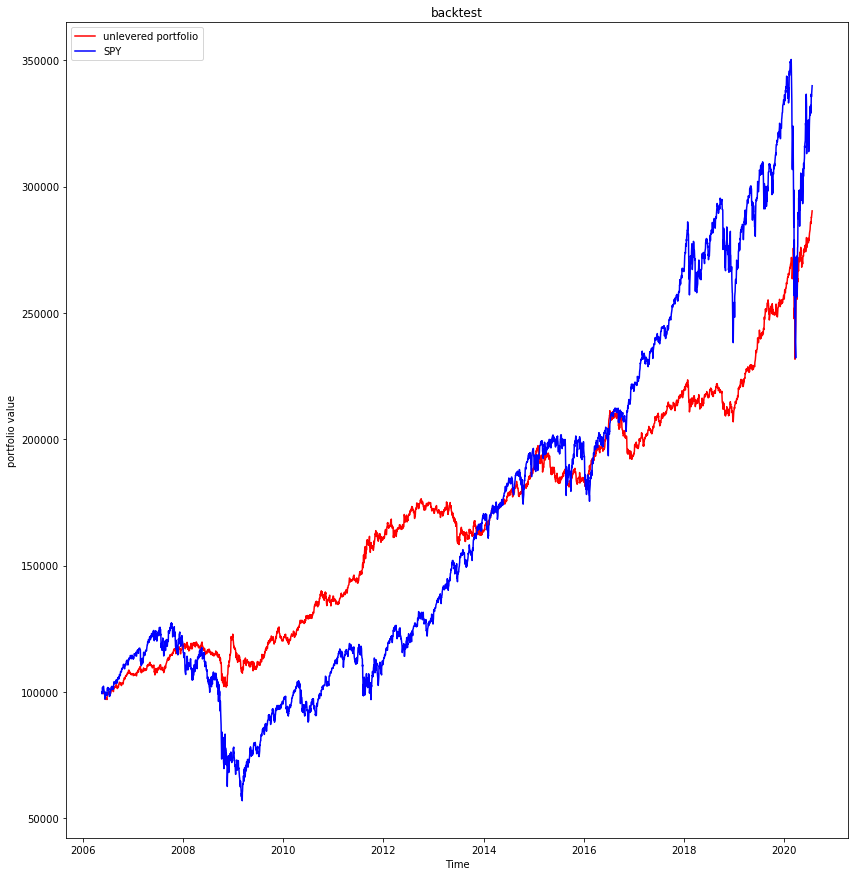

In [84]:
back_test_series = sim_portfolio['my_portfolio Adj Close'] 
benchmark_series = benchmark_portfolio['my_portfolio Adj Close']
plt.figure(figsize = (14,15))
plt.plot(back_test_series, color = 'red', label = 'unlevered portfolio')
plt.plot(benchmark_series, color = 'blue', label = 'SPY')
plt.title('backtest')
plt.xlabel('Time')
plt.ylabel('portfolio value')
plt.legend()
plt.show()

In [ ]:
def back_test(portfolio_df, leverage, margin_int)

In [59]:
ticker_df.pct_change()*1.5-0.5*0.0015

,SPY,IWM,QQQ,GDX,VTI,GLD,USO,TLT,LQD,IEF
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.027840,-0.020804,-0.022753,0.038849,-0.026524,0.021866,-0.083706,0.022813,0.005384,0.008402
2015-01-06,-0.014878,-0.026701,-0.020862,0.078725,-0.015447,0.016348,-0.059824,0.026276,0.005358,0.009327
2015-01-07,0.017942,0.017722,0.018587,-0.028595,0.017149,-0.009587,0.025843,-0.003712,0.001237,-0.001029
2015-01-08,0.025867,0.024693,0.027960,-0.023149,0.025710,-0.007063,0.013948,-0.020614,-0.005586,-0.006867
...,...,...,...,...,...,...,...,...,...,...
2020-06-23,0.006156,0.005570,0.012016,0.020758,0.005130,0.011879,-0.014208,-0.011002,-0.003551,-0.001244
2020-06-24,-0.039013,-0.049421,-0.031673,-0.027467,-0.041464,-0.005976,-0.077526,0.015338,-0.004904,0.002092
2020-06-25,0.015331,0.021908,0.013529,0.008749,0.017393,-0.001654,0.037232,0.003574,0.000826,-0.000503
2020-06-26,-0.036377,-0.041120,-0.036172,0.009118,-0.035638,0.005945,-0.031888,0.015305,0.000599,0.003319


In [ ]:

#returns pct change with leverage
def ticker_df_leverage(ticker_df, margin_int, leverage)

In [ ]:
#https://www.wallstreetmojo.com/capital-allocation-line/
#capital allocation line

#portfolio variance https://www.wallstreetmojo.com/portfolio-variance-formula/